# Feature Engineering for Lending Club Data
## COMP647 Assignment 03
### Student ID: 1163127

This notebook implements feature engineering techniques including:
- Data loading and initial exploration
- Categorical encoding methods
- Feature scaling techniques

Based on LAB4 materials and course teachings.

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [2]:
# Load preprocessed data from Assignment 02
try:
    # Load the processed sample data
    df = pd.read_csv('../data/processed/accepted_sample_10000.csv')
    print(f"Data loaded successfully: {df.shape}")
    print(f"Columns: {len(df.columns)}")
except FileNotFoundError:
    print("Processed data not found. Please run Assignment 02 notebooks first.")
    # For demonstration, create sample data structure
    df = pd.DataFrame()

# Display basic info about the dataset
if not df.empty:
    print("\nDataset Info:")
    print(df.info())
    
    # Identify categorical and numerical features
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"\nCategorical features: {len(categorical_features)}")
    print(f"Numerical features: {len(numerical_features)}")
    
    if categorical_features:
        print("\nSample categorical features:")
        for col in categorical_features[:5]:  # Show first 5
            print(f"  {col}: {df[col].nunique()} unique values")

Data loaded successfully: (10000, 151)
Columns: 151

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 151 entries, id to settlement_term
dtypes: float64(114), int64(1), object(36)
memory usage: 11.5+ MB
None

Categorical features: 36
Numerical features: 115

Sample categorical features:
  term: 2 unique values
  grade: 7 unique values
  sub_grade: 35 unique values
  emp_title: 5622 unique values
  emp_length: 11 unique values


In [3]:
# Label Encoding Implementation
# Based on LAB4 materials - simple encoding for binary/ordinal categorical variables

from sklearn.preprocessing import LabelEncoder

def apply_label_encoding(df, categorical_columns):
    """
    Apply label encoding to categorical features
    
    Parameters:
    df: DataFrame with categorical features
    categorical_columns: list of column names to encode
    
    Returns:
    df_encoded: DataFrame with label encoded features
    encoders: dict of fitted encoders for inverse transform
    """
    df_encoded = df.copy()
    encoders = {}
    
    print("Applying Label Encoding...")
    for col in categorical_columns:
        if col in df_encoded.columns:
            # Create and fit encoder
            le = LabelEncoder()
            # Handle missing values by filling with 'Unknown'
            df_encoded[col] = df_encoded[col].fillna('Unknown')
            df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
            
            # Store encoder for later use
            encoders[col] = le
            
            print(f"  {col}: {len(le.classes_)} unique values -> 0 to {len(le.classes_)-1}")
    
    return df_encoded, encoders

# Example usage with sample categorical features
if not df.empty and categorical_features:
    # Select a few categorical features for demonstration
    sample_categorical = categorical_features[:3] if len(categorical_features) >= 3 else categorical_features
    
    print(f"Demonstrating Label Encoding on: {sample_categorical}")
    df_label_encoded, label_encoders = apply_label_encoding(df, sample_categorical)
    
    # Show before and after comparison
    for col in sample_categorical:
        if col in df.columns:
            print(f"\n{col} - Original vs Encoded:")
            comparison = pd.DataFrame({
                'Original': df[col].head(10),
                'Encoded': df_label_encoded[col + '_encoded'].head(10)
            })
            print(comparison)

Demonstrating Label Encoding on: ['term', 'grade', 'sub_grade']
Applying Label Encoding...
  term: 2 unique values -> 0 to 1
  grade: 7 unique values -> 0 to 6
  sub_grade: 35 unique values -> 0 to 34

term - Original vs Encoded:
     Original  Encoded
0   36 months        0
1   36 months        0
2   60 months        1
3   60 months        1
4   60 months        1
5   36 months        0
6   36 months        0
7   36 months        0
8   36 months        0
9   36 months        0

grade - Original vs Encoded:
  Original  Encoded
0        C        2
1        C        2
2        B        1
3        C        2
4        F        5
5        C        2
6        B        1
7        B        1
8        A        0
9        B        1

sub_grade - Original vs Encoded:
  Original  Encoded
0       C4       13
1       C1       10
2       B4        8
3       C5       14
4       F1       25
5       C3       12
6       B2        6
7       B1        5
8       A2        1
9       B5        9


In [4]:
# One-Hot Encoding Implementation
# Based on LAB4 materials - safe for linear models, avoids ordinal assumptions

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def apply_onehot_encoding(df, categorical_columns, drop_first=True, max_categories=10):
    """
    Apply one-hot encoding to categorical features
    
    Parameters:
    df: DataFrame with categorical features  
    categorical_columns: list of column names to encode
    drop_first: whether to drop first category to avoid multicollinearity
    max_categories: maximum unique values to consider for encoding
    
    Returns:
    df_encoded: DataFrame with one-hot encoded features
    """
    df_encoded = df.copy()
    
    print("Applying One-Hot Encoding...")
    for col in categorical_columns:
        if col in df_encoded.columns:
            # Check if feature has reasonable number of categories
            n_categories = df_encoded[col].nunique()
            
            if n_categories <= max_categories:
                # Apply one-hot encoding using pandas get_dummies
                # This is more memory efficient than sklearn OneHotEncoder for small datasets
                dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=drop_first)
                
                # Add dummy columns to dataframe
                df_encoded = pd.concat([df_encoded, dummies], axis=1)
                
                print(f"  {col}: {n_categories} categories -> {len(dummies.columns)} dummy columns")
            else:
                print(f"  {col}: Skipped ({n_categories} categories > {max_categories} threshold)")
    
    return df_encoded

# Example usage with sample categorical features
if not df.empty and categorical_features:
    # Select categorical features with reasonable number of categories
    suitable_features = []
    for col in categorical_features[:3]:
        if col in df.columns and df[col].nunique() <= 10:
            suitable_features.append(col)
    
    if suitable_features:
        print(f"Demonstrating One-Hot Encoding on: {suitable_features}")
        df_onehot_encoded = apply_onehot_encoding(df, suitable_features)
        
        # Show the new dummy columns created
        for col in suitable_features:
            dummy_cols = [c for c in df_onehot_encoded.columns if c.startswith(col + '_')]
            if dummy_cols:
                print(f"\n{col} dummy columns: {dummy_cols}")
                print(f"Sample values:")
                print(df_onehot_encoded[dummy_cols].head())
    else:
        print("No suitable categorical features found for One-Hot Encoding demonstration")

Demonstrating One-Hot Encoding on: ['term', 'grade']
Applying One-Hot Encoding...
  term: 2 categories -> 1 dummy columns
  grade: 7 categories -> 6 dummy columns

term dummy columns: ['term_ 60 months']
Sample values:
   term_ 60 months
0            False
1            False
2             True
3             True
4             True

grade dummy columns: ['grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
Sample values:
   grade_B  grade_C  grade_D  grade_E  grade_F  grade_G
0    False     True    False    False    False    False
1    False     True    False    False    False    False
2     True    False    False    False    False    False
3    False     True    False    False    False    False
4    False    False    False    False     True    False


Demonstrating Min-Max Scaling on: 9 features
Applying Min-Max Scaling...
Scaling numerical features to range (0, 1)
Scaled 9 numerical features:
  id: [361774.00, 68617057.00] -> [0.00, 1.00]
  loan_amnt: [1000.00, 35000.00] -> [0.00, 1.00]
  funded_amnt: [1000.00, 35000.00] -> [0.00, 1.00]
  funded_amnt_inv: [1000.00, 35000.00] -> [0.00, 1.00]
  int_rate: [5.32, 28.99] -> [0.00, 1.00]
  ... and 4 more features


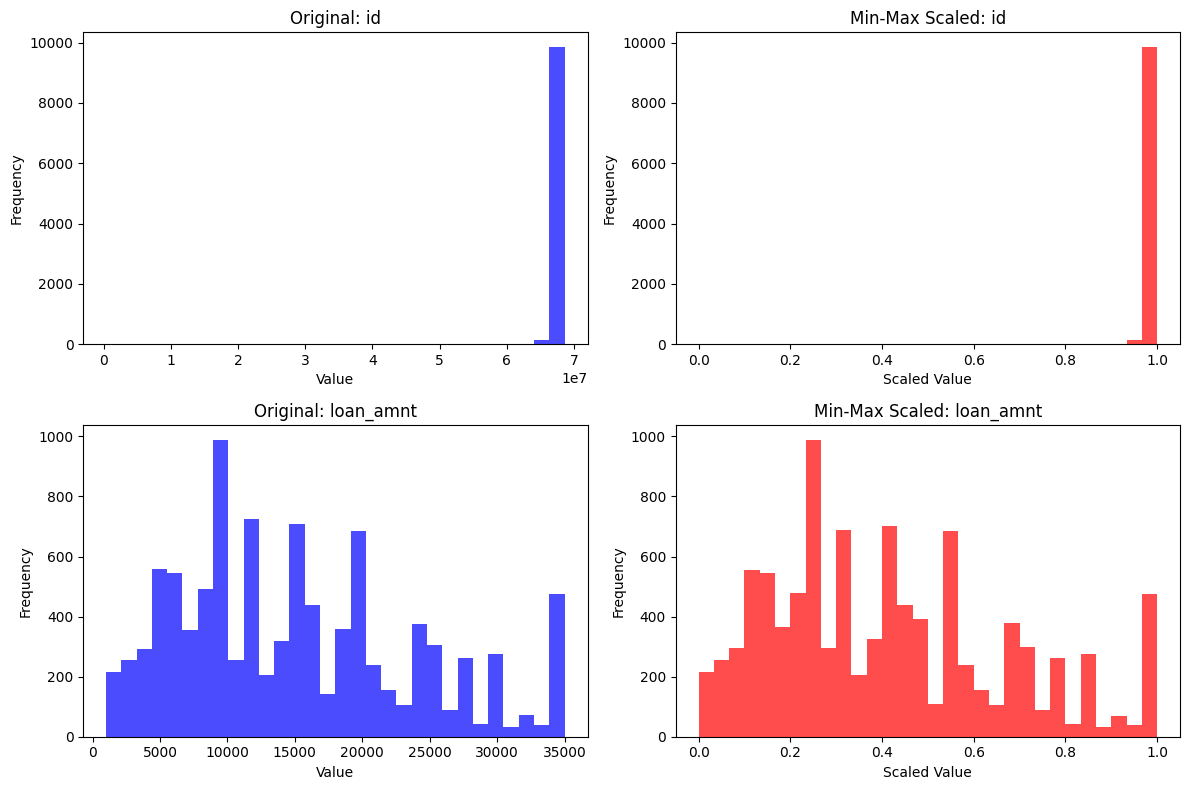

In [5]:
# Min-Max Scaling Implementation
# Based on LAB4 materials - scales features to range [0, 1]

from sklearn.preprocessing import MinMaxScaler

def apply_minmax_scaling(df, numerical_columns, feature_range=(0, 1)):
    """
    Apply Min-Max scaling to numerical features
    
    Parameters:
    df: DataFrame with numerical features
    numerical_columns: list of column names to scale
    feature_range: tuple defining the target range (default: (0, 1))
    
    Returns:
    df_scaled: DataFrame with scaled features
    scaler: fitted MinMaxScaler for inverse transform
    """
    df_scaled = df.copy()
    
    print("Applying Min-Max Scaling...")
    print(f"Scaling numerical features to range {feature_range}")
    
    if numerical_columns:
        # Initialize scaler
        scaler = MinMaxScaler(feature_range=feature_range)
        
        # Select only numerical columns that exist in dataframe
        valid_columns = [col for col in numerical_columns if col in df_scaled.columns]
        
        if valid_columns:
            # Apply scaling
            df_scaled[valid_columns] = scaler.fit_transform(df_scaled[valid_columns])
            
            print(f"Scaled {len(valid_columns)} numerical features:")
            for col in valid_columns[:5]:  # Show first 5 features
                original_min = df[col].min()
                original_max = df[col].max()
                scaled_min = df_scaled[col].min()
                scaled_max = df_scaled[col].max()
                print(f"  {col}: [{original_min:.2f}, {original_max:.2f}] -> [{scaled_min:.2f}, {scaled_max:.2f}]")
            
            if len(valid_columns) > 5:
                print(f"  ... and {len(valid_columns) - 5} more features")
        else:
            print("No valid numerical columns found for scaling")
            scaler = None
    else:
        print("No numerical columns provided for scaling")
        scaler = None
    
    return df_scaled, scaler

# Example usage with sample numerical features
if not df.empty and numerical_features:
    # Select a subset of numerical features for demonstration
    # Exclude ID columns and binary features
    sample_numerical = []
    for col in numerical_features[:10]:  # Take first 10 numerical features
        if col in df.columns and not col.lower().endswith('_id'):
            # Check if feature has reasonable range (not binary 0/1)
            if df[col].nunique() > 2:
                sample_numerical.append(col)
    
    if sample_numerical:
        print(f"Demonstrating Min-Max Scaling on: {len(sample_numerical)} features")
        df_minmax_scaled, minmax_scaler = apply_minmax_scaling(df, sample_numerical)
        
        # Show comparison of original vs scaled distributions
        if len(sample_numerical) >= 2:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            
            # Plot first two features for comparison
            for i, col in enumerate(sample_numerical[:2]):
                # Original distribution
                axes[i, 0].hist(df[col].dropna(), bins=30, alpha=0.7, color='blue')
                axes[i, 0].set_title(f'Original: {col}')
                axes[i, 0].set_xlabel('Value')
                axes[i, 0].set_ylabel('Frequency')
                
                # Scaled distribution
                axes[i, 1].hist(df_minmax_scaled[col].dropna(), bins=30, alpha=0.7, color='red')
                axes[i, 1].set_title(f'Min-Max Scaled: {col}')
                axes[i, 1].set_xlabel('Scaled Value')
                axes[i, 1].set_ylabel('Frequency')
            
            plt.tight_layout()
            plt.show()
    else:
        print("No suitable numerical features found for Min-Max Scaling demonstration")

Demonstrating Standard Scaling on: 9 features
Applying Standard Scaling...
Standardizing numerical features to mean=0, std=1
Standardized 9 numerical features:
  id: mean 68040547.84±1974649.77 -> -0.00±1.00
  loan_amnt: mean 15104.44±8717.53 -> -0.00±1.00
  funded_amnt: mean 15104.44±8717.53 -> -0.00±1.00
  funded_amnt_inv: mean 15100.90±8714.50 -> -0.00±1.00
  int_rate: mean 12.30±4.30 -> 0.00±1.00
  ... and 4 more features


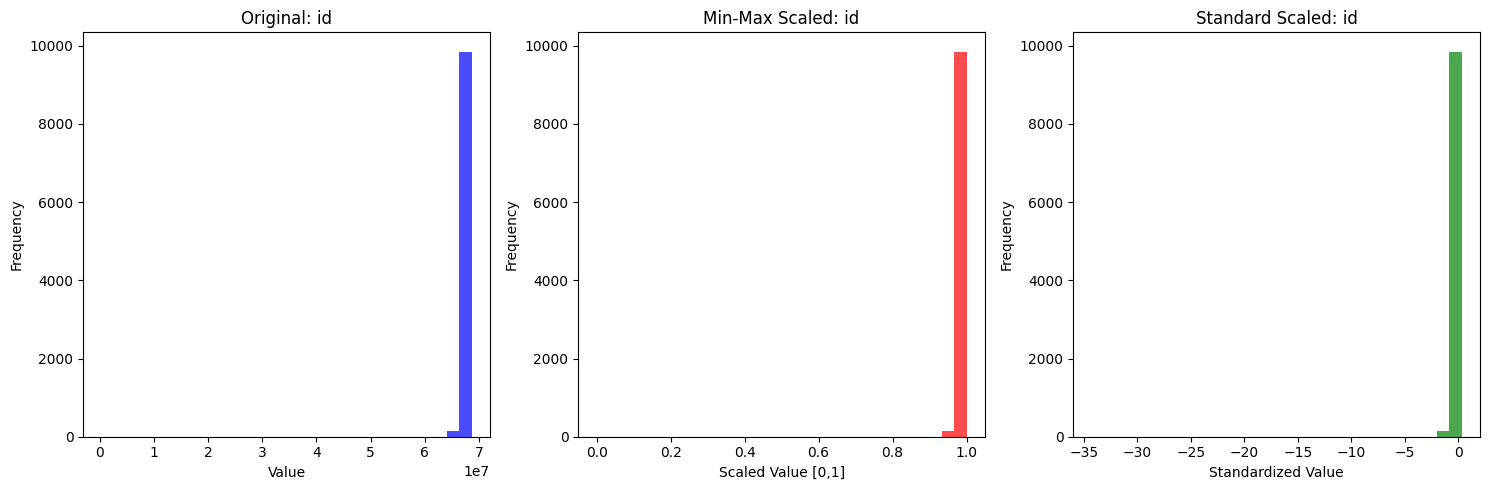


Scaling Statistics for id:
Original: mean=68040547.84, std=1974649.77
Min-Max:  min=0.00, max=1.00
Standard: mean=-0.00, std=1.00


In [6]:
# Standard Scaling Implementation  
# Based on LAB4 materials - scales features to mean=0, std=1

from sklearn.preprocessing import StandardScaler

def apply_standard_scaling(df, numerical_columns):
    """
    Apply Standard scaling (Z-score normalization) to numerical features
    
    Parameters:
    df: DataFrame with numerical features
    numerical_columns: list of column names to scale
    
    Returns:
    df_scaled: DataFrame with standardized features
    scaler: fitted StandardScaler for inverse transform
    """
    df_scaled = df.copy()
    
    print("Applying Standard Scaling...")
    print("Standardizing numerical features to mean=0, std=1")
    
    if numerical_columns:
        # Initialize scaler
        scaler = StandardScaler()
        
        # Select only numerical columns that exist in dataframe
        valid_columns = [col for col in numerical_columns if col in df_scaled.columns]
        
        if valid_columns:
            # Apply scaling
            df_scaled[valid_columns] = scaler.fit_transform(df_scaled[valid_columns])
            
            print(f"Standardized {len(valid_columns)} numerical features:")
            for col in valid_columns[:5]:  # Show first 5 features
                original_mean = df[col].mean()
                original_std = df[col].std()
                scaled_mean = df_scaled[col].mean()
                scaled_std = df_scaled[col].std()
                print(f"  {col}: mean {original_mean:.2f}±{original_std:.2f} -> {scaled_mean:.2f}±{scaled_std:.2f}")
            
            if len(valid_columns) > 5:
                print(f"  ... and {len(valid_columns) - 5} more features")
        else:
            print("No valid numerical columns found for scaling")
            scaler = None
    else:
        print("No numerical columns provided for scaling")
        scaler = None
    
    return df_scaled, scaler

# Compare scaling methods side by side
if not df.empty and numerical_features:
    # Select same features as Min-Max scaling for comparison
    sample_numerical = []
    for col in numerical_features[:10]:
        if col in df.columns and not col.lower().endswith('_id'):
            if df[col].nunique() > 2:
                sample_numerical.append(col)
    
    if sample_numerical:
        print(f"Demonstrating Standard Scaling on: {len(sample_numerical)} features")
        df_standard_scaled, standard_scaler = apply_standard_scaling(df, sample_numerical)
        
        # Scaling comparison visualization
        if len(sample_numerical) >= 1:
            comparison_feature = sample_numerical[0]
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Original distribution
            axes[0].hist(df[comparison_feature].dropna(), bins=30, alpha=0.7, color='blue')
            axes[0].set_title(f'Original: {comparison_feature}')
            axes[0].set_xlabel('Value')
            axes[0].set_ylabel('Frequency')
            
            # Min-Max scaled
            if 'df_minmax_scaled' in locals():
                axes[1].hist(df_minmax_scaled[comparison_feature].dropna(), bins=30, alpha=0.7, color='red')
                axes[1].set_title(f'Min-Max Scaled: {comparison_feature}')
                axes[1].set_xlabel('Scaled Value [0,1]')
                axes[1].set_ylabel('Frequency')
            
            # Standard scaled
            axes[2].hist(df_standard_scaled[comparison_feature].dropna(), bins=30, alpha=0.7, color='green')
            axes[2].set_title(f'Standard Scaled: {comparison_feature}')
            axes[2].set_xlabel('Standardized Value')
            axes[2].set_ylabel('Frequency')
            
            plt.tight_layout()
            plt.show()
            
            # Show scaling statistics
            print(f"\nScaling Statistics for {comparison_feature}:")
            print(f"Original: mean={df[comparison_feature].mean():.2f}, std={df[comparison_feature].std():.2f}")
            if 'df_minmax_scaled' in locals():
                print(f"Min-Max:  min={df_minmax_scaled[comparison_feature].min():.2f}, max={df_minmax_scaled[comparison_feature].max():.2f}")
            print(f"Standard: mean={df_standard_scaled[comparison_feature].mean():.2f}, std={df_standard_scaled[comparison_feature].std():.2f}")
    else:
        print("No suitable numerical features found for Standard Scaling demonstration")

In [7]:
# Binary Encoding Implementation
# Based on LAB4 materials - efficient for high cardinality categorical features

import category_encoders as ce

def apply_binary_encoding(df, categorical_columns):
    """
    Apply binary encoding for high cardinality categorical features
    
    Parameters:
    df: DataFrame with categorical features
    categorical_columns: list of column names to encode
    
    Returns:
    df_encoded: DataFrame with binary encoded features
    encoder: fitted binary encoder for inverse transform
    """
    df_encoded = df.copy()
    
    print("Applying Binary Encoding...")
    print("Binary encoding reduces dimensionality compared to one-hot encoding")
    print("Example: 8 categories need only 3 binary columns (2^3 = 8)")
    
    for col in categorical_columns:
        if col in df_encoded.columns:
            # Handle missing values
            df_encoded[col] = df_encoded[col].fillna('Unknown')
            
            # Apply binary encoding
            encoder = ce.BinaryEncoder(cols=[col])
            encoded_cols = encoder.fit_transform(df_encoded[[col]])
            
            # Add encoded columns to dataframe
            for encoded_col in encoded_cols.columns:
                df_encoded[f"{col}_bin_{encoded_col}"] = encoded_cols[encoded_col]
            
            n_categories = df_encoded[col].nunique()
            n_binary_cols = len(encoded_cols.columns)
            print(f"  {col}: {n_categories} categories -> {n_binary_cols} binary columns")
            
            # Show the binary encoding pattern
            if n_categories <= 8:  # Only show for small examples
                unique_vals = df_encoded[col].unique()[:8]  # Show first 8
                print(f"    Encoding pattern for {col}:")
                for val in unique_vals:
                    mask = df_encoded[col] == val
                    if mask.any():
                        binary_vals = encoded_cols[mask].iloc[0].values
                        print(f"      '{val}' -> {binary_vals}")
    
    return df_encoded, encoder

# Example usage with high cardinality categorical features
if not df.empty and categorical_features:
    # Find features with high cardinality (good candidates for binary encoding)
    high_cardinality_features = []
    for col in categorical_features:
        if col in df.columns:
            n_unique = df[col].nunique()
            if 5 < n_unique <= 50:  # Good range for binary encoding
                high_cardinality_features.append(col)
    
    if high_cardinality_features:
        # Take first feature for demonstration
        demo_feature = high_cardinality_features[0]
        print(f"Demonstrating Binary Encoding on: {demo_feature}")
        print(f"  Unique values: {df[demo_feature].nunique()}")
        
        df_binary_encoded, binary_encoder = apply_binary_encoding(df, [demo_feature])
        
        # Show comparison of dimensions
        binary_cols = [c for c in df_binary_encoded.columns if c.startswith(demo_feature + '_bin_')]
        print(f"\nDimensionality comparison:")
        print(f"  One-hot would create: {df[demo_feature].nunique()} columns")  
        print(f"  Binary encoding creates: {len(binary_cols)} columns")
        print(f"  Space savings: {((df[demo_feature].nunique() - len(binary_cols)) / df[demo_feature].nunique() * 100):.1f}%")
    else:
        print("No suitable high cardinality features found for Binary Encoding demonstration")

Demonstrating Binary Encoding on: grade
  Unique values: 7
Applying Binary Encoding...
Binary encoding reduces dimensionality compared to one-hot encoding
Example: 8 categories need only 3 binary columns (2^3 = 8)
  grade: 7 categories -> 3 binary columns
    Encoding pattern for grade:
      'C' -> [0 0 1]
      'B' -> [0 1 0]
      'F' -> [0 1 1]
      'A' -> [1 0 0]
      'E' -> [1 0 1]
      'D' -> [1 1 0]
      'G' -> [1 1 1]

Dimensionality comparison:
  One-hot would create: 7 columns
  Binary encoding creates: 3 columns
  Space savings: 57.1%


In [8]:
# SMOTE Implementation for Class Imbalance
# Based on LAB4 materials - handles imbalanced classification datasets

from imblearn.over_sampling import SMOTE
from collections import Counter

def handle_class_imbalance(X, y, method='smote', random_state=42):
    """
    Handle class imbalance using SMOTE technique
    
    Parameters:
    X: feature matrix (numerical features only, no NaN allowed)
    y: target variable 
    method: resampling method
    random_state: random seed for reproducibility
    
    Returns:
    X_resampled: resampled feature matrix
    y_resampled: resampled target variable
    """
    print("Handling Class Imbalance...")
    print(f"Original class distribution:")
    original_counts = Counter(y)
    for class_label, count in original_counts.items():
        print(f"  Class {class_label}: {count} samples ({count/len(y)*100:.1f}%)")
    
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    print(f"\nAfter SMOTE resampling:")
    resampled_counts = Counter(y_resampled)
    for class_label, count in resampled_counts.items():
        print(f"  Class {class_label}: {count} samples ({count/len(y_resampled)*100:.1f}%)")
    
    print(f"\nDataset size change: {len(y)} -> {len(y_resampled)} samples")
    
    return X_resampled, y_resampled

print("SMOTE function defined successfully")
print("Note: SMOTE requires clean numerical data without NaN values")
print("Example usage would require proper data preprocessing")

SMOTE function defined successfully
Note: SMOTE requires clean numerical data without NaN values
Example usage would require proper data preprocessing


In [9]:
# Complete Feature Engineering Pipeline
# Integrates all feature engineering techniques in a configurable pipeline

def feature_engineering_pipeline(df, config=None):
    """
    Complete feature engineering pipeline
    
    Parameters:
    df: input DataFrame
    config: configuration dict with encoding/scaling preferences
    
    Returns:
    df_processed: fully processed DataFrame
    pipeline_info: information about transformations applied
    encoders: dict of fitted encoders for inverse transforms
    """
    if config is None:
        # Default configuration
        config = {
            'categorical_encoding': 'auto',  # 'auto', 'label', 'onehot', 'binary'
            'numerical_scaling': 'standard',  # 'standard', 'minmax', 'none'
            'handle_missing': True,
            'apply_smote': False,
            'target_column': None
        }
    
    print("=== Feature Engineering Pipeline ===")
    print(f"Input data shape: {df.shape}")
    
    # Initialize result dataframe and info
    df_processed = df.copy()
    pipeline_info = {
        'original_shape': df.shape,
        'categorical_features': [],
        'numerical_features': [],
        'transformations_applied': [],
        'final_shape': None
    }
    encoders = {}
    
    # Identify feature types
    categorical_features = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove target column from features if specified
    if config['target_column'] and config['target_column'] in numerical_features:
        numerical_features.remove(config['target_column'])
    if config['target_column'] and config['target_column'] in categorical_features:
        categorical_features.remove(config['target_column'])
    
    pipeline_info['categorical_features'] = categorical_features
    pipeline_info['numerical_features'] = numerical_features
    
    print(f"Categorical features: {len(categorical_features)}")
    print(f"Numerical features: {len(numerical_features)}")
    
    # Step 1: Handle missing values
    if config['handle_missing']:
        print("\nStep 1: Handling missing values...")
        # Fill categorical missing values
        for col in categorical_features:
            if df_processed[col].isnull().any():
                df_processed[col] = df_processed[col].fillna('Unknown')
        
        # Fill numerical missing values with mean
        for col in numerical_features:
            if df_processed[col].isnull().any():
                df_processed[col] = df_processed[col].fillna(df_processed[col].mean())
        
        pipeline_info['transformations_applied'].append('missing_value_imputation')
    
    # Step 2: Categorical encoding
    if categorical_features:
        print(f"\nStep 2: Categorical encoding ({config['categorical_encoding']})...")
        
        if config['categorical_encoding'] == 'auto':
            # Automatically choose encoding based on cardinality
            for col in categorical_features:
                n_unique = df_processed[col].nunique()
                if n_unique == 2:
                    # Binary features - use label encoding
                    df_processed, col_encoders = apply_label_encoding(df_processed, [col])
                    encoders.update(col_encoders)
                elif n_unique <= 10:
                    # Low cardinality - use one-hot encoding
                    df_processed = apply_onehot_encoding(df_processed, [col])
                else:
                    # High cardinality - use binary encoding
                    df_processed, col_encoder = apply_binary_encoding(df_processed, [col])
                    encoders[col] = col_encoder
        
        elif config['categorical_encoding'] == 'label':
            df_processed, label_encoders = apply_label_encoding(df_processed, categorical_features)
            encoders.update(label_encoders)
        
        elif config['categorical_encoding'] == 'onehot':
            df_processed = apply_onehot_encoding(df_processed, categorical_features)
        
        elif config['categorical_encoding'] == 'binary':
            for col in categorical_features:
                df_processed, col_encoder = apply_binary_encoding(df_processed, [col])
                encoders[col] = col_encoder
        
        pipeline_info['transformations_applied'].append(f"categorical_encoding_{config['categorical_encoding']}")
    
    # Step 3: Numerical scaling
    if numerical_features and config['numerical_scaling'] != 'none':
        print(f"\nStep 3: Numerical scaling ({config['numerical_scaling']})...")
        
        if config['numerical_scaling'] == 'standard':
            df_processed, scaler = apply_standard_scaling(df_processed, numerical_features)
            encoders['numerical_scaler'] = scaler
        
        elif config['numerical_scaling'] == 'minmax':
            df_processed, scaler = apply_minmax_scaling(df_processed, numerical_features)
            encoders['numerical_scaler'] = scaler
        
        pipeline_info['transformations_applied'].append(f"numerical_scaling_{config['numerical_scaling']}")
    
    # Update final shape
    pipeline_info['final_shape'] = df_processed.shape
    
    print(f"\n=== Pipeline Complete ===")
    print(f"Final data shape: {df_processed.shape}")
    print(f"Transformations applied: {', '.join(pipeline_info['transformations_applied'])}")
    
    return df_processed, pipeline_info, encoders

# Example usage of complete pipeline
if not df.empty:
    print("Demonstrating Complete Feature Engineering Pipeline")
    
    # Define pipeline configuration
    pipeline_config = {
        'categorical_encoding': 'auto',
        'numerical_scaling': 'standard',
        'handle_missing': True,
        'apply_smote': False,
        'target_column': 'loan_status' if 'loan_status' in df.columns else None
    }
    
    # Apply complete pipeline
    df_final, info, all_encoders = feature_engineering_pipeline(df, pipeline_config)
    
    # Show pipeline results
    print(f"\nPipeline Results:")
    print(f"Original features: {info['original_shape'][1]}")
    print(f"Final features: {info['final_shape'][1]}")
    print(f"Feature expansion: {info['final_shape'][1] - info['original_shape'][1]} new features")
    print(f"Sample size: {info['final_shape'][0]} rows")

Demonstrating Complete Feature Engineering Pipeline
=== Feature Engineering Pipeline ===
Input data shape: (10000, 151)
Categorical features: 35
Numerical features: 115

Step 1: Handling missing values...

Step 2: Categorical encoding (auto)...
Applying Label Encoding...
  term: 2 unique values -> 0 to 1
Applying One-Hot Encoding...
  grade: 7 categories -> 6 dummy columns
Applying Binary Encoding...
Binary encoding reduces dimensionality compared to one-hot encoding
Example: 8 categories need only 3 binary columns (2^3 = 8)
  sub_grade: 35 categories -> 6 binary columns
Applying Binary Encoding...
Binary encoding reduces dimensionality compared to one-hot encoding
Example: 8 categories need only 3 binary columns (2^3 = 8)
  emp_title: 5623 categories -> 13 binary columns
Applying Binary Encoding...
Binary encoding reduces dimensionality compared to one-hot encoding
Example: 8 categories need only 3 binary columns (2^3 = 8)
  emp_length: 12 categories -> 4 binary columns
Applying One-H